# Circularity vs Stellar Age

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as patches

/u/fiza/conda-envs/auriga/lib/python3.7/site-packages/setuptools/_importlib.py:23: UserWarning: `importlib-metadata` version is incompatible with `setuptools`.
This problem is likely to be solved by installing an updated version of `importlib-metadata`.
  warnings.warn(msg)  # Ensure a descriptive message is shown.


In [46]:
from auriga.images import figure_setup
from auriga.snapshot import Snapshot
from auriga.settings import Settings
from auriga.parser import parse

In [15]:
figure_setup()
settings = Settings()

#### Config

In [4]:
N_BINS = 200
MIN_PART_COUNT = 1E1
MAX_PART_COUNT = 1E3

#### `read_data`

In [8]:
def read_data(simulation: str) -> pd.DataFrame:
    """
    This method returns a data frame with the circularity (`Circularity`) and
    the stellar age in Gyr (`StellarAge_Gyr`) for each star. Note that
    `StellarAge_Gyr` is the stellar age and not the formation time.

    Parameters
    ----------
    simulation : str
        The simulation to load.

    Returns
    -------
    data : pd.DataFrame
        The data frame.
    """
    s = Snapshot(simulation=simulation, loadonlytype=[0, 1, 2, 3, 4, 5])
    s.add_circularity()
    s.add_stellar_age()

    is_real_star = (s.type == 4) & (s.stellar_formation_time > 0)
    is_main_obj = (s.halo == s.halo_idx) & (s.subhalo == s.subhalo_idx)

    data = pd.DataFrame({
        "Circularity": s.circularity[is_real_star & is_main_obj],
        "StellarAge_Gyr": s.stellar_age[is_real_star & is_main_obj],
        "CylindricalRadius_ckpc": s.rho[is_real_star & is_main_obj],
        "zPosition_ckpc": s.pos[is_real_star & is_main_obj, 2],
    })

    return data

### Test: Particle Positions

In [56]:
def make_test_plot(simulation: str, min_circ: float, max_circ: float,
                   min_age: float, max_age: float) -> None:
    galaxy = parse(simulation)[0]
    data = read_data(simulation=f"au{galaxy}_or_l4_s127")
    mask = (data["Circularity"] <= max_circ) \
        & (data["Circularity"] >= min_circ) \
            & (data["StellarAge_Gyr"] <= max_age) \
                & (data["StellarAge_Gyr"] >= min_age)
    
    fig = plt.figure(figsize=(5, 2))
    gs = fig.add_gridspec(nrows=1, ncols=2, hspace=0.0, wspace=0.5)
    axs = gs.subplots(sharex=False, sharey=False)

    axs[0].tick_params(which='both', direction="in")
    axs[0].set_xlim(0, 14)
    axs[0].set_xticks([2, 4, 6, 8, 10, 12])
    axs[0].set_ylim(-1.4, 1.4)
    axs[0].set_yticks([-1, -0.5, 0, 0.5, 1.0])
    axs[0].set_axisbelow(True)
    axs[0].set_xlabel("Stellar Age [Gyr]")
    axs[0].tick_params(labelbottom=True)
    axs[0].set_ylabel(r'$\epsilon = j_z \, j_\mathrm{circ}^{-1}$')

    axs[0].hist2d(
        data["StellarAge_Gyr"], data["Circularity"],
        cmap='nipy_spectral',
        bins=N_BINS,
        range=[axs[0].get_xlim(), axs[0].get_ylim()],
        norm=mcolors.LogNorm(vmin=MIN_PART_COUNT, vmax=MAX_PART_COUNT),
        rasterized=True)

    rect = patches.Rectangle((min_age, min_circ), max_age - min_age,
                             max_circ - min_circ, linewidth=1.0,
                            edgecolor='r', facecolor='none')
    axs[0].add_patch(rect)

    axs[0].text(
        x=0.05, y=0.95, s=r"$\texttt{" + f"Au{galaxy}" + "}$", color="white",
        size=6.0, transform=axs[0].transAxes, ha='left', va='top')

    axs[1].tick_params(which='both', direction="in")
    axs[1].set_xlim(0.0, 100.0)
    axs[1].set_ylim(-50.0, 50.0)
    axs[1].set_axisbelow(True)
    axs[1].set_xlabel(r"$r_{xy}$ [ckpc]")
    axs[1].tick_params(labelbottom=True)
    axs[1].set_ylabel(r"$z$ [ckpc]")

    axs[1].scatter(
        data["CylindricalRadius_ckpc"][mask], data["zPosition_ckpc"][mask],
        s=1.0, linewidths=0.0, alpha=0.1)

    axs[1].text(
        x=0.05, y=0.95, s=r"$\texttt{" + f"Au{galaxy}" + "}$", color="black",
        size=6.0, transform=axs[1].transAxes, ha='left', va='top')

    plt.show()

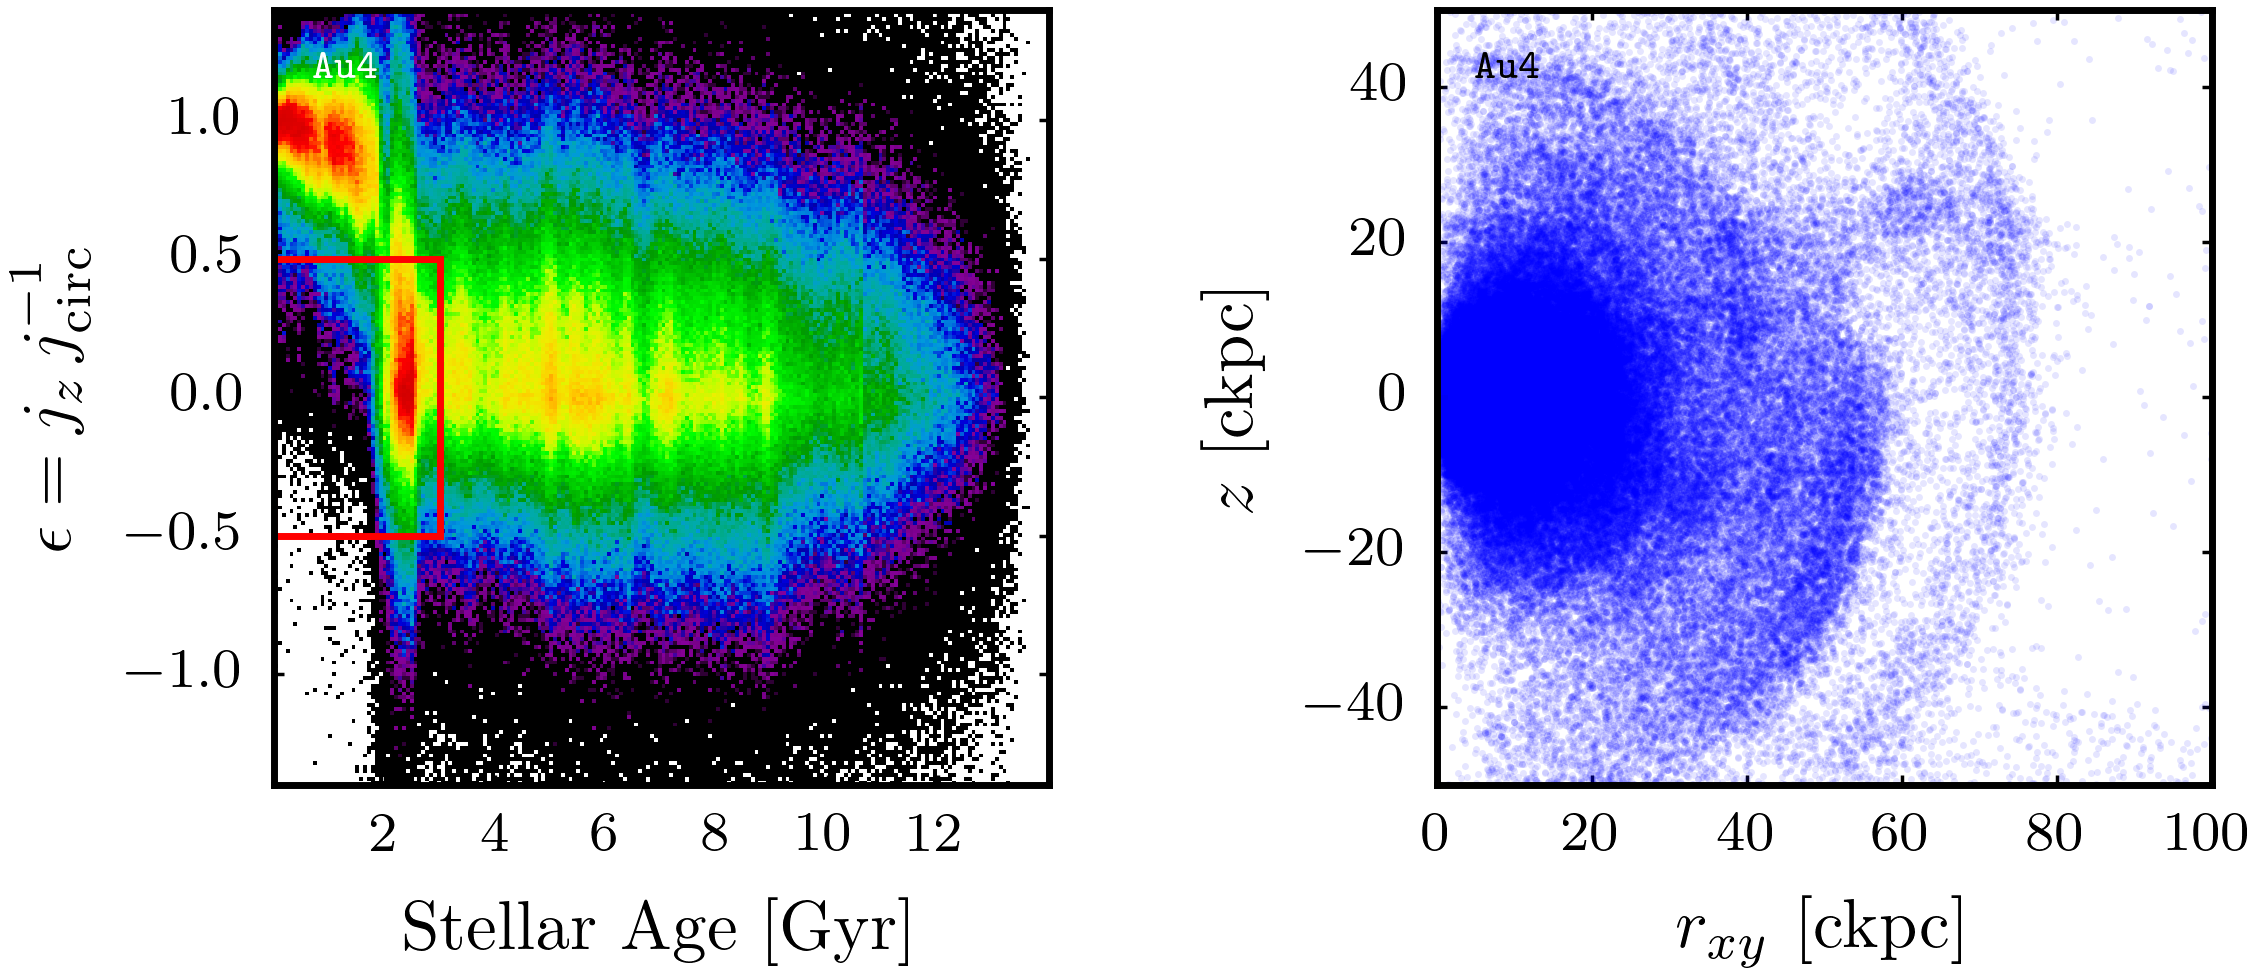

In [57]:
make_test_plot(simulation="au4_or_l4_s127",
               min_circ=-0.5, max_circ=0.5,
               min_age=0.0, max_age=3.0)

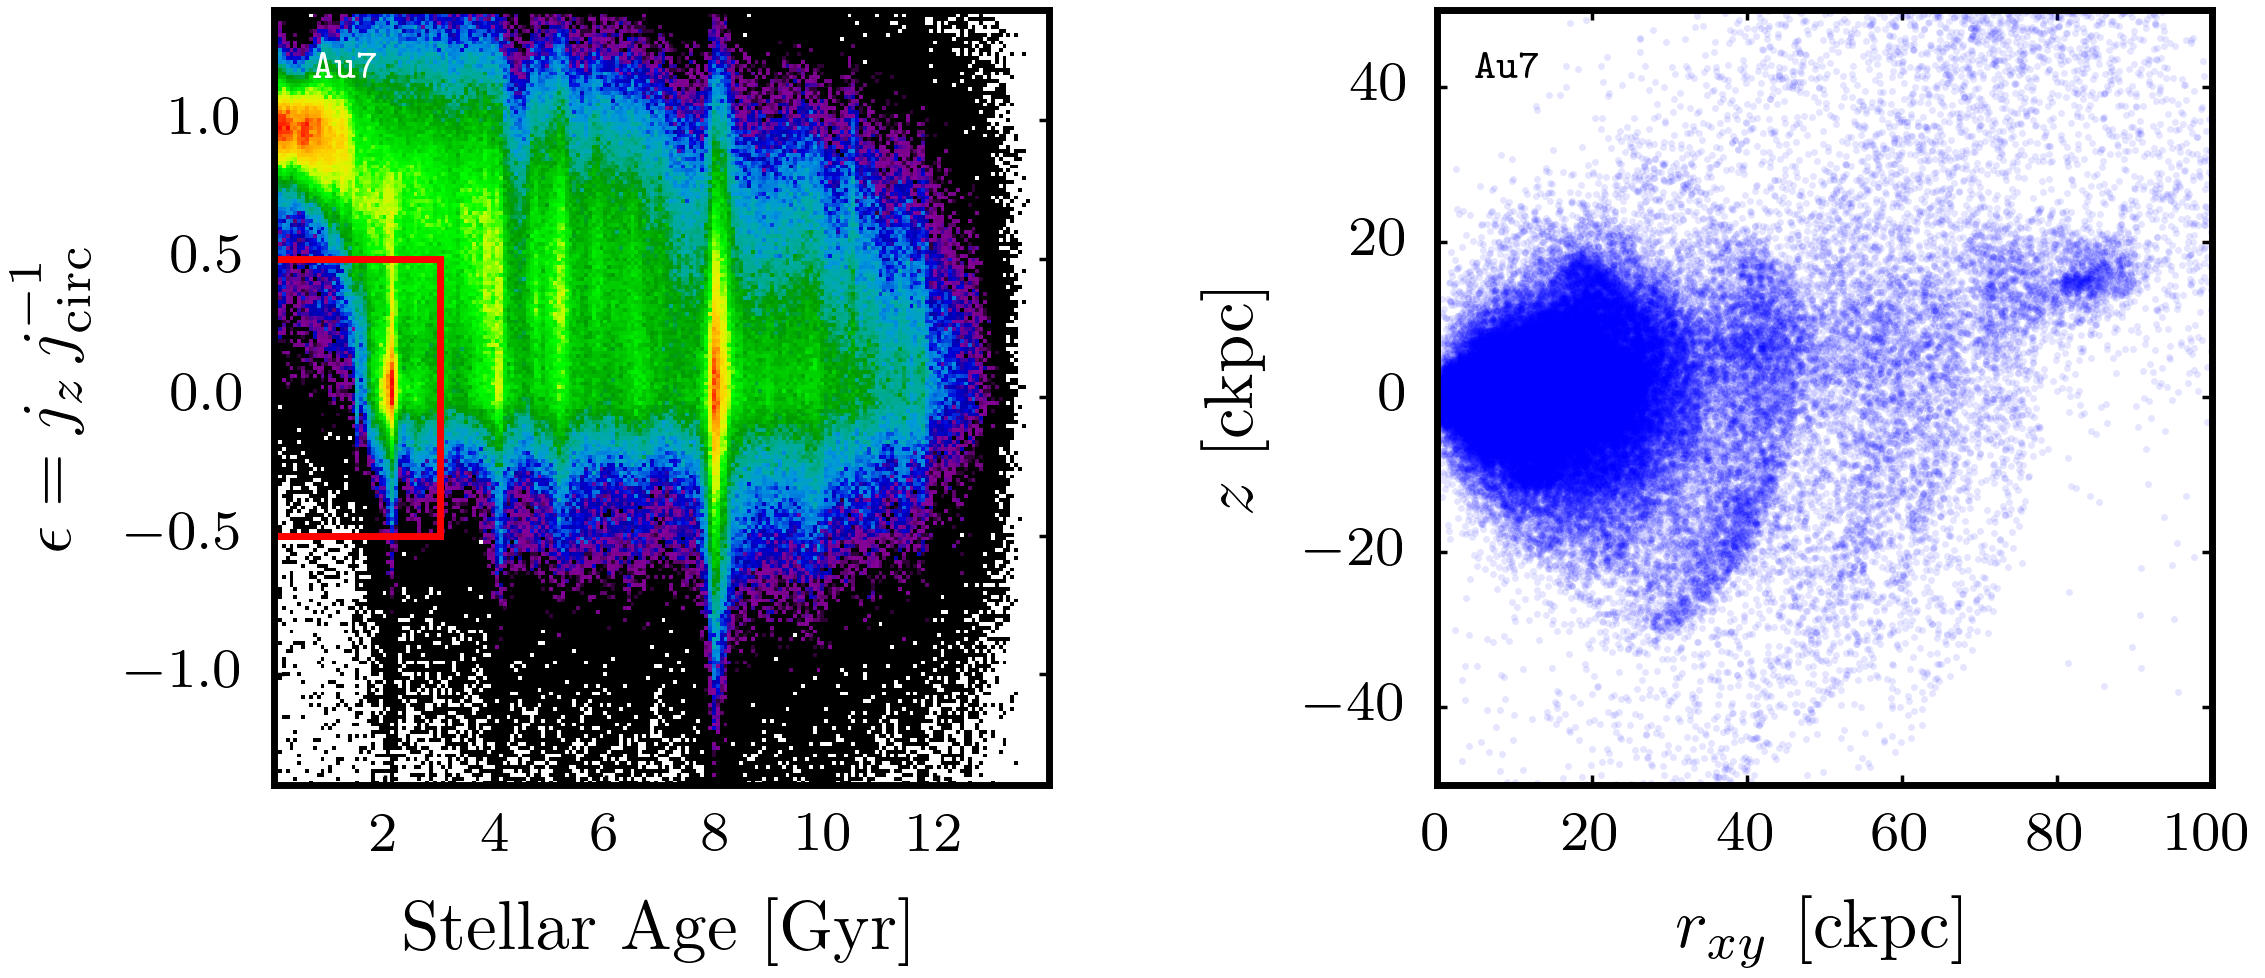

In [58]:
make_test_plot(simulation="au7_or_l4_s127",
               min_circ=-0.5, max_circ=0.5,
               min_age=0.0, max_age=3.0)

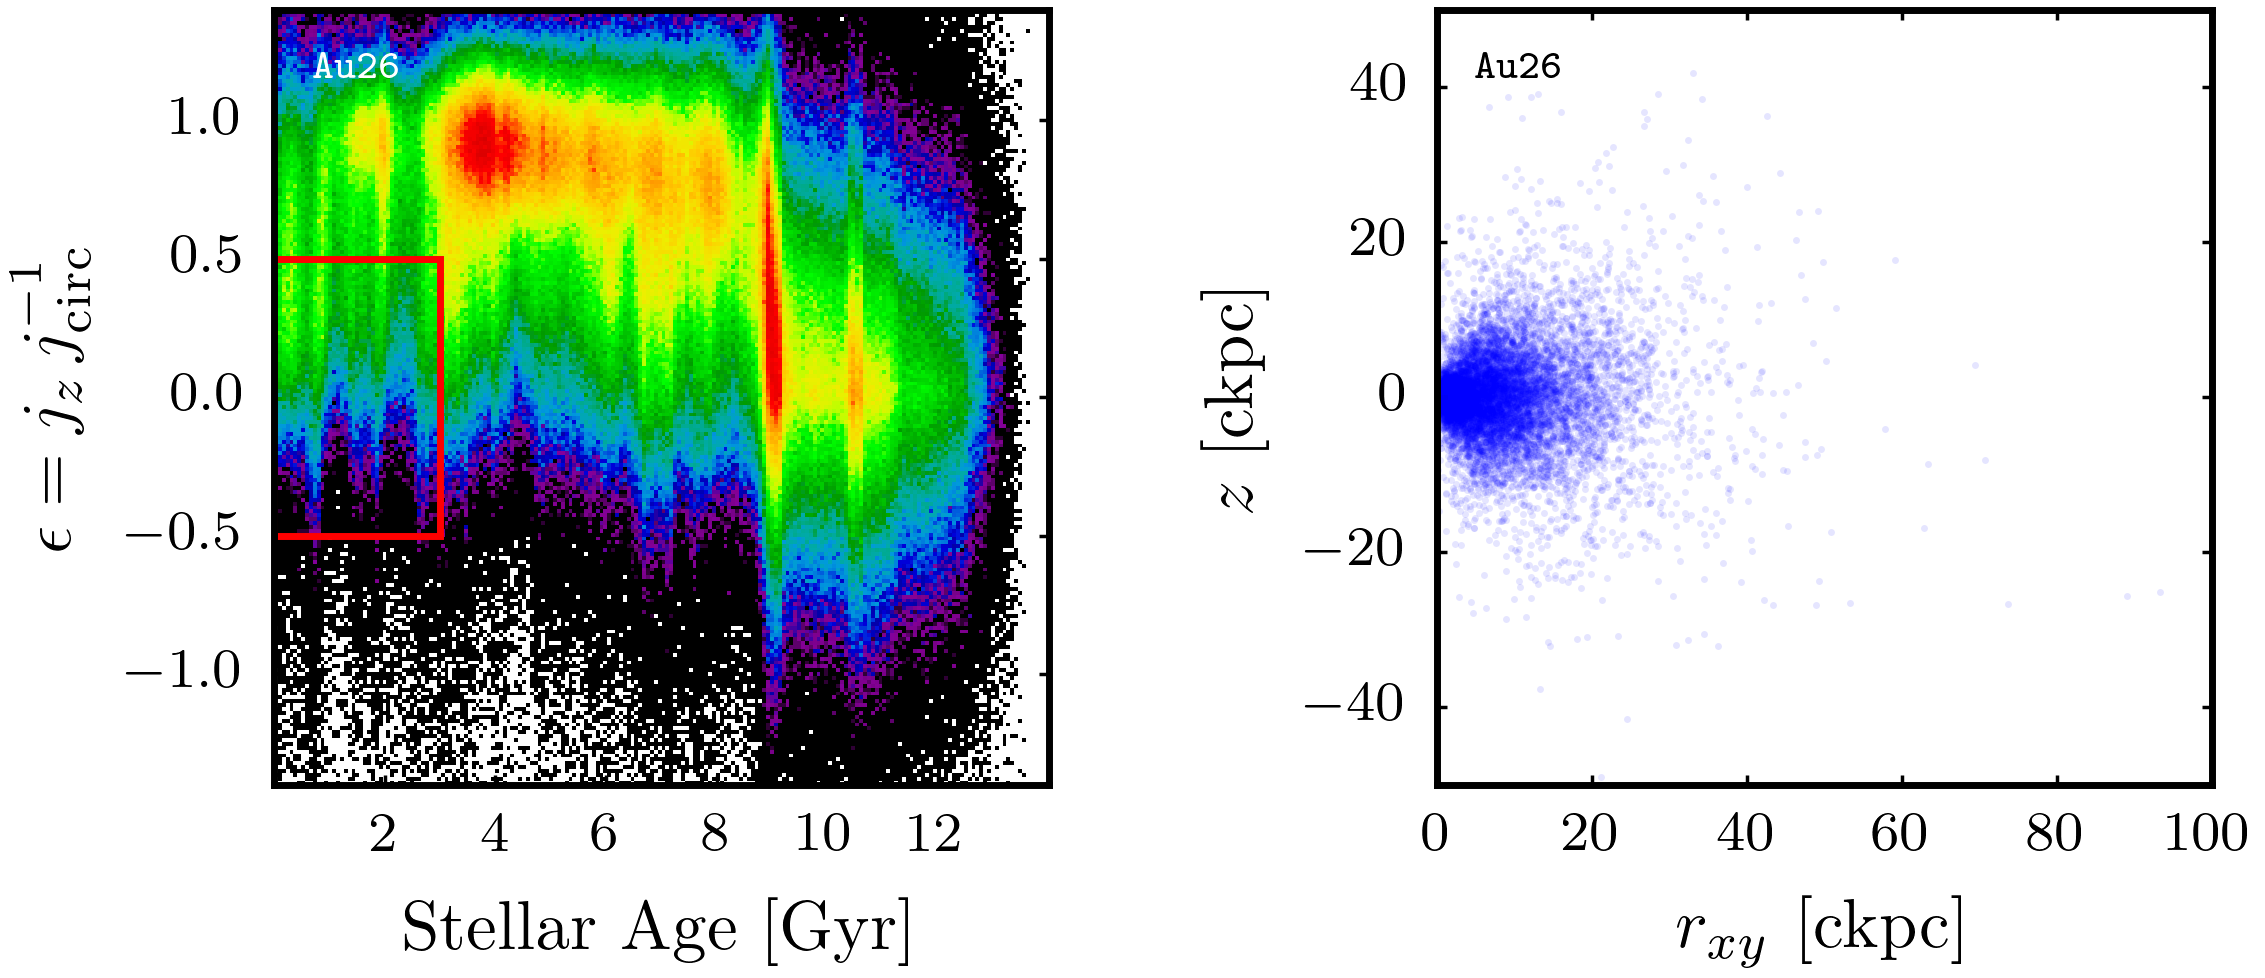

In [59]:
make_test_plot(simulation="au26_or_l4_s127",
               min_circ=-0.5, max_circ=0.5,
               min_age=0.0, max_age=3.0)

#### Figures

In [ ]:
fig = plt.figure(figsize=(7, 8))
gs = fig.add_gridspec(nrows=6, ncols=4, hspace=0.0, wspace=0.0)
axs = gs.subplots(sharex=True, sharey=True)

for ax in axs.flatten():
    ax.tick_params(which='both', direction="in")
    if ax == axs[-1, -1]: ax.axis("off")
    ax.set_xlim(0, 14)
    ax.set_xticks([2, 4, 6, 8, 10, 12])
    ax.set_ylim(-1.4, 1.4)
    ax.set_yticks([-1, -0.5, 0, 0.5, 1.0])
    ax.set_axisbelow(True)
    if ax.get_subplotspec().is_last_row() or ax == axs[-2, -1]:
        ax.set_xlabel("Stellar Age [Gyr]")
        ax.tick_params(labelbottom=True)
    if ax.get_subplotspec().is_first_col():
        ax.set_ylabel(r'$\epsilon = j_z \, j_\mathrm{circ}^{-1}$')

for i in range(len(settings.groups["Included"])):
    ax = axs.flatten()[i]
    galaxy = settings.groups["Included"][i]
    label = f"Au{galaxy}"
    simulation = f"au{galaxy}_or_l4_s127"
    df = read_data(simulation=simulation)
    _, _, _, qm = ax.hist2d(
        df["StellarAge_Gyr"], df["Circularity"],
        cmap='nipy_spectral',
        bins=N_BINS,
        range=[ax.get_xlim(), ax.get_ylim()],
        norm=mcolors.LogNorm(vmin=MIN_PART_COUNT, vmax=MAX_PART_COUNT),
        rasterized=True)

    ax.text(x=0.05, y=0.05, s=r"$\texttt{" + label + "}$", color="black",
            size=6.0, transform=ax.transAxes, ha='left', va='bottom')

    if galaxy == 2:
        cbar = plt.colorbar(qm, ax=axs.flatten()[-1], shrink=0.8,
                            location="bottom", pad=3)
        cbar.set_ticks([1E1, 1E2, 1E3])
        cbar.set_label(f"$N_\star$")

    fig.savefig("../images/circularity_vs_stellar_age/included.pdf")

plt.close(fig)

: 

: 